# MANOCCA example notebook

This notebook gives on overview on how to use MANOCCA. It is divided in 3 parts : 
- Example of MANOCCA on data simulated without any signal (Null Hypothesis)
- Example of MANOCCA without PCA applied on a dataset where N1 data were derived using a corMat1, and N2 using a modified correlation matrix corMat2
- Example of MANOCCA with PCA on the same data

On the examples with changes in the correlation structure, examples using the Explainer tool or displayed.

In [3]:
import numpy as np
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.insert(0, 'src/') # path from your venv to the src
sys.path.insert(0, 'src/tools') # same but to src\\tools

In [6]:
# import of my scaling function
from tools.preprocessing_tools import scale

# First example : Null hypothesis
In this scenario, the test runs on data without any signal

In [7]:
#loading tools
from manocca import MANOCCA

In [8]:
# Set up
N_samples = 1000
K_outputs = 10 # needs to be at least 2 to compute at least one covariance
K_predictors = 1

In [14]:
outputs = np.random.normal(0,1,(N_samples,K_outputs))
predictors = np.random.binomial(1,0.4,(N_samples,K_predictors))

In [12]:
# Compute the model : Y ~ X + C 
manocca = MANOCCA(predictors, # pd.DataFrame or np.ndarray : the matrix or vector X in the model, the predictor of covariance.
                  outputs, # pd.DataFrame or np.ndarray : the matrix Y in the model, in other words the covariance to study.
                  covariates = None, # pd.DataFrame or np.ndarray : the C in the model, the covariates to adjust.
                  cols_outputs = None, # specify column names of outputs, by default they are the column names of the pandas.DataFrame
                  cols_predictors = None, # specify column names of predictor, by default they are the column names of the pandas.DataFrame
                  cols_covariates = None, # specify column names of covariates, by default they are the column names of the pandas.DataFrame
                  prodV_red = None, # you can input a previous computed prodV_red (can be retrieved from manocca.prodV_red) to avoid unnecessary computation 
                  n_comp = None, # number of principal components to use, by default it will be min(N_samples, K_outputs*(K_outputs - 1)/2)
                  prod_to_keep = None, # usually None, unless you want to restrain the analysis to a specific list of products, ex : ['var1|var2','var1|var5',...] 
                  use_resid = True, # use residuals to adjust the covariates
                  use_pca = True, # use pca to reduce the dimension of the product matrix
                  n_jobs = 1 # number of jobs to use in parallel processing 
                 )

Sequential computation of prodV
(1000, 45)


In [15]:
manocca.test()

manocca.p

array([[0.53604736]])

# Simulation set up

In [45]:
#loading tools
from simulation import Simu

In [62]:
# Set up
N_samples = 1000
K_outputs = 10 # needs to be at least 2 to compute at least one covariance
K_predictors = 1

In [64]:
real_cormat = np.array([[ 1.        ,  0.48280721,  0.00694387,  0.01185877, -0.07160852],
       [ 0.48280721,  1.        , -0.31682176, -0.32171591, -0.38747333],
       [ 0.00694387, -0.31682176,  1.        ,  0.9997097 ,  0.95207874],
       [ 0.01185877, -0.32171591,  0.9997097 ,  1.        ,  0.94824819],
       [-0.07160852, -0.38747333,  0.95207874,  0.94824819,  1.        ]])

In [90]:
noise_cormat = np.corrcoef(np.random.normal(0,1,(100,K_outputs)).T)

In [92]:
corMat1 = noise_cormat.copy()


corMat2 = noise_cormat.copy()
n_changes = real_cormat.shape[1]
corMat2[:n_changes, :n_changes] = real_cormat

In [87]:
from plotly import subplots
import plotly.express as px

In [95]:
px.imshow(corMat1, zmin = -1, zmax = 1)

In [96]:
px.imshow(corMat2, zmin = -1, zmax = 1)

In [116]:
# Get data
N1 = 600
N2 = 400

Y1 = np.random.multivariate_normal(np.zeros((K_outputs)), corMat1, N1)
Y2 = np.random.multivariate_normal(np.zeros((K_outputs)), corMat2, N2)

outputs = np.vstack([Y1,Y2])
predictors = scale(np.array([0]*N1 + [1]*N2)).reshape(-1,1)

In [120]:
# Compute the model : Y ~ X + C 
manocca = MANOCCA(predictors, # pd.DataFrame or np.ndarray : the matrix or vector X in the model, the predictor of covariance.
                  outputs, # pd.DataFrame or np.ndarray : the matrix Y in the model, in other words the covariance to study.
                  covariates = None, # pd.DataFrame or np.ndarray : the C in the model, the covariates to adjust.
                  cols_outputs = None, # specify column names of outputs, by default they are the column names of the pandas.DataFrame
                  cols_predictors = None, # specify column names of predictor, by default they are the column names of the pandas.DataFrame
                  cols_covariates = None, # specify column names of covariates, by default they are the column names of the pandas.DataFrame
                  prodV_red = None, # you can input a previous computed prodV_red (can be retrieved from manocca.prodV_red) to avoid unnecessary computation 
                  n_comp = None, # number of principal components to use, by default it will be min(N_samples, K_outputs*(K_outputs - 1)/2)
                  use_pca = False,
                  use_resid = True, # use residuals to adjust the covariates
                  n_jobs = 1 # number of jobs to use in parallel processing 
                 )

Sequential computation of prodV
(1000, 45)


In [121]:
# Test
manocca.test()
manocca.p

array([[1.13107553e-62]])

## Explainer

In [126]:
from explainer import Explainer

import matplotlib.pyplot as plt

In [127]:
exp = Explainer(manocca)

In [128]:
L_p, grid = exp.power_pc_kept(0, # index or column name of predictor to use 
                              grid = None, # grid of principal components to use
                              max_n_comp = None, # maximum number of principal components to use
                              plot = False  # plot the distribution of p_values 
                 ) # returns the list of p_value and grid of PC used (in order to plot easily)

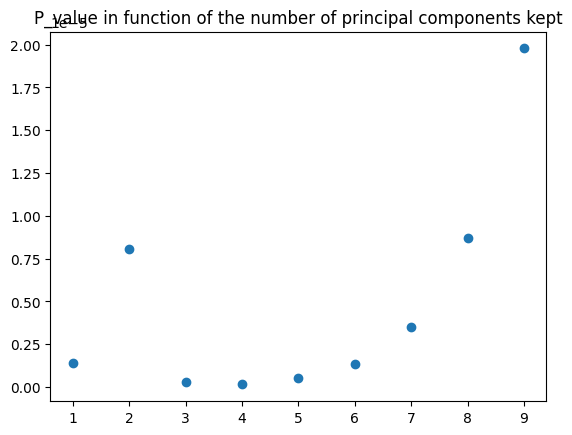

In [129]:
plt.scatter(grid, L_p)
plt.title("P_value in function of the number of principal components kept")
plt.show()

In [130]:
help(exp.univariate_cov)

Help on method univariate_cov in module explainer:

univariate_cov(var, n_comp, plot=True, return_beta=False) method of explainer.Explainer instance



In [131]:
L_p = exp.univariate_cov(0, # index or column name of predictor to use
                         n_comp = 10, # number of principal components to keep. Raw variables are used if no pca
                         plot = False # plot results
                        )# returns : list of p_value for each top n_comp principal component

In [ ]:
9x

In [145]:
top_features = exp.feature_importances(0, # variable to analyse
                                       45, # number of components to keep in the model, here no pca so 9*10/2
                                       threshold = "all" # recommmended to put n_comp for more information see function in code
                                      )

top_features

2|3    15.840724
2|8    13.095522
2|4    12.637296
0|6    11.716113
3|8    11.659382
6|8    11.536831
3|4    11.311464
7|8    11.142019
0|9    10.356145
5|7    10.353478
0|3    10.016239
4|8     9.815617
1|8     9.453384
0|4     8.936801
8|9     8.452821
0|8     8.418161
2|5     7.846580
1|2     7.704520
2|9     7.413016
5|8     6.808950
1|3     6.467895
0|7     6.437792
5|6     6.291863
6|9     6.076976
0|2     5.808870
5|9     5.667323
3|5     5.558400
1|4     5.557993
4|5     5.375809
2|7     5.338912
1|6     5.005194
1|9     4.790401
4|7     4.661163
3|6     4.422659
1|7     4.355766
6|7     4.287842
7|9     4.282209
2|6     4.274055
3|7     4.210974
0|5     4.188987
3|9     3.991382
0|1     3.959290
1|5     3.264746
4|6     2.553956
4|9     2.343414
dtype: float64

In [136]:
### Showcasing explainer when PCA is used

In [139]:
manocca_pca = MANOCCA(predictors, outputs, n_comp = 20, use_pca = True, use_resid = True, n_jobs = 1)
manocca_pca.test()
manocca_pca.p

Sequential computation of prodV
(1000, 45)


array([[5.51503741e-70]])

In [142]:
# loading new explainer
exp = Explainer(manocca_pca)

In [144]:
top_features = exp.feature_importances(0, # variable to analyse
                                       10, # number of components to keep in the model
                                       threshold = "n_comp" # recommmended to put n_comp for more information see function in code
                                      )

top_features

2|3    14.438440
2|4    12.177980
6|8    11.153553
0|6    10.637898
3|8    10.620160
3|4    10.211200
2|8     9.989652
4|8     8.814332
0|3     8.303466
0|4     7.903225
0|9     7.893458
8|9     7.687243
1|2     6.746916
7|8     6.049892
1|8     5.460073
0|2     4.984492
1|3     4.750265
0|8     4.653049
4|5     4.376414
1|4     4.256757
4|7     4.045651
5|6     3.933774
1|6     3.829079
3|5     3.793773
6|7     3.655599
2|9     3.583326
0|7     3.532801
5|9     3.351419
5|8     3.301056
2|5     3.274431
3|7     3.265065
0|5     3.219046
1|7     3.113433
3|6     2.799421
2|7     2.673389
1|9     2.519230
7|9     2.430885
3|9     2.300177
6|9     2.250169
2|6     2.195862
4|6     1.082045
4|9     0.967612
0|1     0.924138
5|7     0.857678
1|5     0.291445
dtype: float64

In [143]:
### Slightly depreciated function
# This function was developed before feature_importances(), and had for objective to detail differences in loadings for 
# significant PCs.
# Now feature_importances() retrieves the overall top important products 
exp.significant_covariance(0, # which pc to analyse, you can use univariate_cov to get significant principal components /!\ starts at 0
                           10 # number of loadings to display
                          )

3         4         2         7   8   0   1         6         9   5
3       NaN       NaN       NaN  0.022729 NaN NaN NaN -0.108299  0.003714 NaN
4       NaN       NaN       NaN       NaN NaN NaN NaN  0.033699  0.029792 NaN
2       NaN       NaN       NaN -0.031355 NaN NaN NaN -0.320273 -0.188165 NaN
7  0.022729       NaN -0.031355       NaN NaN NaN NaN -0.191883 -0.081919 NaN
8       NaN       NaN       NaN       NaN NaN NaN NaN       NaN       NaN NaN
0       NaN       NaN       NaN       NaN NaN NaN NaN       NaN       NaN NaN
1       NaN       NaN       NaN       NaN NaN NaN NaN       NaN       NaN NaN
6 -0.108299  0.033699 -0.320273 -0.191883 NaN NaN NaN       NaN       NaN NaN
9  0.003714  0.029792 -0.188165 -0.081919 NaN NaN NaN       NaN       NaN NaN
5       NaN       NaN       NaN       NaN NaN NaN NaN       NaN       NaN NaN